In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import multiprocessing as multi
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, interpn
from scipy.optimize import linprog
import seaborn as sns
import sys
from tqdm import tqdm_notebook, tqdm

d = 'vt'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

sns.set_style('ticks')
sns.set_palette('colorblind')
sns.set_context('notebook')

In [3]:
MMin = 5
MMax = 50

def draw_m1m2(size=1):
    u1s = np.random.uniform(size=size)
    u2s = np.random.uniform(size=size)
    
    m1s = exp(u1s*log(MMax) + (1-u1s)*log(MMin))
    m2s = m1s*u2s + MMin*(1-u2s)
    
    return (m1s, m2s)

In [54]:
R0 = 60.0 # Gpc^-3 yr^-1
T = 5.0 # yr
gamma = 2.7

zMax = 1.75

zs = expm1(linspace(log(1), log(1+zMax), 1024))
dNdz = T*R0*duty_cycle*(1+zs)**(gamma-1)*4*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value
Nz = cumtrapz(dNdz, zs, initial=0)

icdf_z = interp1d(Nz/Nz[-1], zs)

def draw_z(factor=1):
    N = np.random.poisson(Nz[-1]*factor)
    
    return icdf_z(np.random.uniform(size=N))

In [55]:
def draw_ra_dec(size=1):
    ra = np.random.uniform(low=0, high=2*pi, size=size)
    sin_dec = np.random.uniform(low=-1, high=1, size=size)
    
    return ra, arcsin(sin_dec)

In [56]:
r_bao = 100/0.7/1000 # Gpc
w_bao = 15/0.7/1000 # Gpc
A_bao = 0.01

def xi_bao(r):
    return A_bao*exp(-0.5*square(r-r_bao)/(w_bao*w_bao))

cutoff_scale = 1/1000 # Gpc

def xi_pl(r):
    r = np.atleast_1d(r)
    a = 1.8
    
    return np.where(r < cutoff_scale, 1 - 0.1*(r/cutoff_scale), (r/cutoff_scale)**(-a)*0.9)

print('BAO correlation length is {:.3f} Gpc'.format(r_bao))
print('Width of BAO Gaussian is {:.3f} Gpc'.format(w_bao))

BAO correlation length is 0.143 Gpc
Width of BAO Gaussian is 0.021 Gpc


In [57]:
def bao_covariance(xs):
    rvec = xs[newaxis,:,:] - xs[:,newaxis,:]
    rs = np.sqrt(np.sum(rvec*rvec, axis=2))
    xi_rs = xi_bao(rs) + xi_pl(rs)
    
    return xi_rs

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


Text(0, 0.5, '$\\xi(r)$')

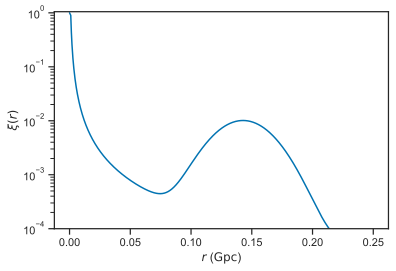

In [58]:
rs = linspace(0, 0.25, 1000)
xi_rs = xi_bao(rs) + xi_pl(rs)
plot(rs, xi_rs)
W_bao = trapz(4*pi*rs*rs*xi_rs, rs)

axis(ymin=1e-4)

yscale('log')

xlabel(r'$r$ ($\mathrm{Gpc}$)')
ylabel(r'$\xi(r)$')

In [59]:
rs = linspace(0, 1, 2048)
k8 = 1.0/(8/0.7/1000)/(2*pi) # 1/Gpc; note I am using inverse wavelength, not wavenumber (i.e. note the 2*pi)
P8 = trapz(2*rs*(xi_bao(rs) + xi_pl(rs))*sin(2*pi*k8*rs)/k8, rs)*1e9 # Mpc^3

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


In [60]:
print('Power on 8 Mpc scales is {:g} Mpc^3'.format(P8))
sigma_8 = 0.9 # Mpc^3
A2 = sigma_8/P8
print('So fractional amplitude variance parameter is {:g}'.format(A2))

Power on 8 Mpc scales is 695.182 Mpc^3
So fractional amplitude variance parameter is 0.00129463


In [68]:
fmin = 9.0
fref = 40.0
psdstart = 10.0

snr_thresh = 8*sqrt(2) # 8 in at least two detectors

def next_pow_two(x):
    x2 = 1
    while x2 < x:
        x2 = x2 << 1
    
    return x2

def generate_waveform(m1, m2, z):
    dL = cosmo.Planck15.luminosity_distance(z).to(u.Gpc).value
        
    tmax = vt.ls.SimInspiralChirpTimeBound(fmin, m1*(1+z)*vt.lal.MSUN_SI, m2*(1+z)*vt.lal.MSUN_SI, 0.0, 0.0) + 2
    
    df = 1.0/next_pow_two(tmax)
    fmax = 2048.0 # Hz --- based on max freq of 5-5 inspiral
    
    cos_i = np.random.uniform(low=-1, high=1)
    phi_ref = np.random.uniform(low=0, high=2*pi)
    
    hp, hc = vt.ls.SimInspiralChooseFDWaveform((1+z)*m1*vt.lal.MSUN_SI, (1+z)*m2*vt.lal.MSUN_SI, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, dL*1e9*vt.lal.PC_SI, arccos(cos_i), phi_ref, 0.0, 0.0, 0.0, df, fmin, fmax, fref, None, vt.ls.IMRPhenomPv2)
    
    return hp, hc

def compute_detector_snrs(hp, hc, ra, dec):
    psi = np.random.uniform(low=0, high=2*pi)
    gmst = np.random.uniform(low=0, high=2*pi)
    
    snrs = []
    for det in ['H1', 'L1', 'V1']:
        Fp, Fc = vt.lal.ComputeDetAMResponse(vt.lal.cached_detector_by_prefix[det].response, ra, dec, psi, gmst)
        
        h = vt.lal.CreateCOMPLEX16FrequencySeries("h", vt.lal.LIGOTimeGPS(0), 0.0, hp.deltaF, hp.sampleUnits, hp.data.length)
        h.data.data = Fp*hp.data.data + Fc*hc.data.data
        
        fmax = hp.deltaF*(hp.data.length - 1)
        df = hp.deltaF
        Nf = hp.data.length

        fs = linspace(0, fmax, Nf)
        sel = fs > psdstart

        sffs = vt.lal.CreateREAL8FrequencySeries("psds", 0, 0.0, df, vt.lal.DimensionlessUnit, fs.shape[0])
        if det == 'H1' or det == 'L1':
            vt.ls.SimNoisePSDaLIGOaLIGODesignSensitivityT1800044(sffs, psdstart)
        elif det == 'V1':
            vt.ls.SimNoisePSDAdVDesignSensitivityP1200087(sffs, psdstart)
        else:
            raise ValueError('detector must be one of H1, L1, V1')
        
        rho = vt.ls.MeasureSNRFD(h, sffs, psdstart, -1.0)
        n = randn()
        
        snrs.append(sqrt((rho+n)*(rho+n)))
        
    return array(snrs)

def approx_mdet_threshold(z):
    # Come from a constrained optimization problem.
    m, b = array([19.87217405, -0.47620653])
    return m*z + b

def draw_snr(m1, m2, z, ra, dec):
    if m1 < approx_mdet_threshold(z):
        return (m1, m2, z, ra, dec, 0.0)
    else:
        hp, hc = generate_waveform(m1, m2, z)
        snrs = compute_detector_snrs(hp, hc, ra, dec)
        snr = np.sqrt(np.sum(snrs*snrs))

        return (m1,m2,z,ra,dec,snr)

def draw_snr_onearg(x):
    return draw_snr(*x)

def downselect(m1s, m2s, zs, ras, decs, processes=None):
    m1s_sel = []
    m2s_sel = []
    zs_sel = []
    ras_sel = []
    decs_sel = []
    snrs_sel = []
    
    #s = m1s > approx_mdet_threshold(zs)
    p = multi.Pool(processes=processes)
    try:
        for m1, m2, z, ra, dec, snr in tqdm(p.imap(draw_snr_onearg, zip(m1s, m2s, zs, ras, decs), chunksize=1024), total=len(zs)):
            if snr > snr_thresh:
                m1s_sel.append(m1)
                m2s_sel.append(m2)
                zs_sel.append(z)
                ras_sel.append(ra)
                decs_sel.append(dec)
                snrs_sel.append(snr)
    finally:
        p.close()
            
    return array(m1s_sel), array(m2s_sel), array(zs_sel), array(ras_sel), array(decs_sel), array(snrs_sel)

In [62]:
f = exp(5*sqrt(A2))
print('Factor = {:.2f}'.format(f))

rstate = np.random.get_state()
try:
    np.random.seed(3932330617)
    zs = draw_z(factor=f)
    N = len(zs)
    m1s, m2s = draw_m1m2(size=N)
    ras, decs = draw_ra_dec(size=N)

    m1s_sel, m2s_sel, zs_sel, ras_sel, decs_sel, snrs_sel = downselect(m1s, m2s, zs, ras, decs, processes=4)
finally:
    np.random.set_state(rstate)

Factor = 1.20


100%|██████████| 340338/340338 [09:33<00:00, 593.64it/s] 


In [63]:
# parameters are (m, b) in m*z + b
zmax = np.max(zs)
c = [-0.5*zmax*zmax, -zmax]

Aub = column_stack((zs_sel, ones_like(zs_sel)))
bub = m1s_sel

sol = linprog(c, Aub, bub, bounds=[(0, None), (None, 0)])

In [64]:
sol

     con: array([], dtype=float64)
     fun: -36.99488053260869
 message: 'Optimization terminated successfully.'
     nit: 11
   slack: array([20.72541642, 27.99415957, 21.76552199, ..., 29.54664179,
       31.51519247, 19.1863353 ])
  status: 0
 success: True
       x: array([24.84021756, -0.59525817])

In [65]:
0.8*sol.x

array([19.87217405, -0.47620653])

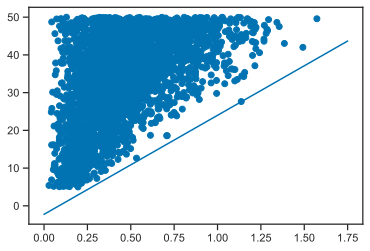

In [66]:
scatter(zs_sel, m1s_sel)
z = linspace(0, zMax ,100)
plot(z, approx_mdet_threshold(z))

In [67]:
len(m1s_sel)

2917

In [37]:
dc_sel = Planck15.comoving_distance(zs_sel).to(u.Gpc).value
xyz_sel = dc_sel[:,newaxis]*np.column_stack((cos(ras_sel)*cos(decs_sel), sin(ras_sel)*cos(decs_sel), sin(decs_sel)))

In [38]:
rij_sel = xyz_sel[:,newaxis,:] - xyz_sel[newaxis,:,:]
r2ij_sel = np.sum(rij_sel*rij_sel, axis=2)
rij_sel = np.sqrt(r2ij_sel)
C = A2*(xi_bao(rij_sel) + xi_pl(rij_sel))

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


In [19]:
L = np.linalg.cholesky(C)

In [20]:
rstate = np.random.get_state()
try:
    np.random.seed(3455602267)
    
    dn = np.dot(L, randn(L.shape[1]))
    
    n0_sel = T*R0*duty_cycle*(1+zs_sel)**(gamma-1)*4*pi*Planck15.differential_comoving_volume(zs_sel).to(u.Gpc**3/u.sr).value
    nmax = f*n0_sel
    n = exp(log(n0_sel) + dn)
    
    rs = np.random.uniform(low=0, high=nmax)
    s = rs < n

    m1s_sel_corr = m1s_sel[s]
    m2s_sel_corr = m2s_sel[s]
    zs_sel_corr = zs_sel[s]
    ras_sel_corr = ras_sel[s]
    decs_sel_corr = decs_sel[s]
    snrs_sel_corr = snrs_sel[s]
finally:
    np.random.set_state(rstate)

In [21]:
with h5py.File('better-comoving-positions.h5', 'w') as f:
    def cd(n, d):
        f.create_dataset(n, data=d, compression='gzip', shuffle=True)
    cd('m1s', m1s_sel_corr)
    cd('m2s', m2s_sel_corr)
    cd('zs', zs_sel_corr)
    cd('dcs', Planck15.comoving_distance(zs_sel_corr).to(u.Gpc).value)
    cd('dls', Planck15.luminosity_distance(zs_sel_corr).to(u.Gpc).value)
    cd('ras', ras_sel_corr)
    cd('decs', decs_sel_corr)
    cd('snrs', snrs_sel_corr)

In [22]:
with h5py.File('better-comoving-positions.h5', 'r') as f:
    m1s_sel = array(f['m1s'])
    m2s_sel = array(f['m2s'])
    zs_sel = array(f['zs'])
    ras_sel = array(f['ras'])
    decs_sel = array(f['decs'])
    snrs_sel = array(f['snrs'])

In [47]:
with h5py.File('better-comoving-positions-random.h5', 'w') as f:
    N = 100
    for i in range(N):
        zs = draw_z()
        NN = len(zs)
        m1s, m2s = draw_m1m2(size=NN)
        ras, decs = draw_ra_dec(size=NN)

        m1, m2, z, ra, dec, snr = downselect(m1s, m2s, zs, ras, decs, processes=4)
    
        g = f.create_group(str(i))
        def cd(n, d):
            g.create_dataset(n, data=d, compression='gzip', shuffle=True)
        cd('m1s', m1)
        cd('m2s', m2)
        cd('zs', z)
        cd('dcs', Planck15.comoving_distance(z).to(u.Gpc).value)
        cd('dls', Planck15.luminosity_distance(z).to(u.Gpc).value)
        cd('ras', ra)
        cd('decs', dec)
        cd('snrs', snr)

100%|██████████| 157580/157580 [02:13<00:00, 1184.79it/s]
